In [1]:
from preprocess import Preprocessor

import ml_inference
from ml_inference import (
    BaselineRegressor, AutoRegressor, cross_val_plot, error_plot
)

import pandas as pd

pd.options.mode.chained_assignment = None
INFILE = '../data/pennycook_et_al_study2_clean.csv'

In [181]:
df = pd.read_csv(INFILE)
X, treat, y = df.drop(columns='Diff'), df.Treatment, df.Diff
df.head()

,SharingType_1,SharingType_2,SharingType_3,SharingType_4,SharingType_6,SharingType_5,SocialMedia_1,SocialMedia_2,SocialMedia_3,SocialMedia_4,...,Education,Income,English,Partisan,Social_Conserv,Economic_Conserv,Treatment,Diff,Party,POTUS2016
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,17.0,9.0,1.0,3.0,1.0,2.0,1.0,-0.200000,Democrat,Clinton
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,19.0,3.0,1.0,5.0,4.0,4.0,0.0,-0.666667,Republican,Trump
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,16.0,7.0,1.0,3.0,2.0,2.0,0.0,0.000000,Independent,Clinton
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,13.0,4.0,1.0,2.0,4.0,4.0,0.0,0.000000,Democrat,Clinton
4,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,14.0,6.0,1.0,1.0,5.0,5.0,0.0,0.200000,Democrat,Clinton


In [3]:
from sklearn.linear_model import LinearRegression


class BaselineTreatmentRegressor(LinearRegression):
    def __init__(self, treatment_var):
        self.treatment_var = treatment_var
        super().__init__()
        
    def fit(self, X, y, sample_weight=None):
        return super().fit(self.transform_X(X), y, sample_weight)
        
    def predict(self, X):
        return super().predict(self.transform_X(X))
    
    def transform_X(self, X):
        return (
            X[self.treatment_var].values if isinstance(X, pd.DataFrame)
            else X[:, self.treatment_var]
        ).reshape(-1, 1)

In [4]:
def get_treatment_idx(treatment_var, X):
    if not isinstance(X, pd.DataFrame):
         X = pd.DataFrame(X)
    return pd.get_dummies(X[treatment_var])

In [194]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

class TreatmentRegressor():
    def __init__(self, models, treatment_var, constrained=False, scoring=r2_score):
        self.models = models
        self.treatment_arms = list(models.keys())
        self.treatment_var = treatment_var
        self.scoring = scoring
        self.constrained = constrained
        
    def fit(self, X, y):
        def fit_weights(X, y):
            X_t = self.transform_X(X)
            self.constrained_weight_ = fit_constrained_weight(X_t, y)
            resid = y - (X_t * self.constrained_weight_).sum(axis=1)
            split = treatment_split(self.treatment_var, X, [X_t, resid])
            self.weight_ = pd.DataFrame(
                {key: fit_unconstrained_weight(X, resid) 
                for key, (_, X, resid) in split.items()}
            )[self.treatment_arms]
            
        def fit_constrained_weight(X, y):
            # constrain weights to sum to 1
            reference = X.columns[0]
            y -= X[reference]
            X = X.apply(lambda x: x-X[reference]).drop(columns=reference)
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            return pd.Series(
                index=self.treatment_arms,
                data=np.insert(reg.coef_, 0, 1-reg.coef_.sum())
            )
        
        def fit_unconstrained_weight(X, y):
            # residual weights sum to 0
            # INCREASE THE WEIGHT UNTIL ALL COEFS ARE BETWEEN 0 AND 1
            # make this the lower bound
            reg = Ridge(500, fit_intercept=False).fit(X, y)
            return (reg.coef_ - reg.coef_.mean()) + self.constrained_weight_

        X, y = X.reset_index(drop=True), y.reset_index(drop=True)
        # store means and stds for each treatment arm
        self.mean_ = y.groupby(X[self.treatment_var]).mean()
        self.std_ = y.groupby(X[self.treatment_var]).std()
        # standardize y for each condition
        treatment_idx = self.get_treatment_idx(X)
        y = (y - treatment_idx @ self.mean_) / (treatment_idx @ self.std_)
        # train models for each treatment arm
        split = treatment_split(self.treatment_var, X, y)
        [self.models[key].fit(X, y) for key, (X, y) in split.items()]
        # fit weights
        fit_weights(X, y)
        return self
    
    def get_treatment_idx(self, X):
        idx = get_treatment_idx(self.treatment_var, X)
        return idx[self.treatment_arms].reset_index(drop=True)

    def predict(self, X):
        treatment_idx = self.get_treatment_idx(X)
        X = self.transform_X(X)
        if self.constrained:
            y_pred = (self.constrained_weight_ * X).sum(axis=1)
        else:
            y_pred = ((treatment_idx @ self.weight_.T) * X).sum(axis=1)
        return y_pred * (treatment_idx @ self.std_) + treatment_idx @ self.mean_
    
    def predict_effect(self, X, control_val=0, treatment_val=1):
        def unnormalize(df, value):
            df[value] = df[value] * self.std_[value] + self.mean_[value]
            
        X = self.transform_X(X)
        y_pred = X @ self.weight_[[control_val, treatment_val]]
        unnormalize(y_pred, control_val)
        unnormalize(y_pred, treatment_val)
        return y_pred[treatment_val] - y_pred[control_val]
        
    def transform_X(self, X):
        X = (
            X.drop(columns=self.treatment_var) if isinstance(X, pd.DataFrame) 
            else np.delete(X, self.treatment_var, axis=1)
        )
        return pd.DataFrame({
            key: model.predict(X) for key, model in self.models.items()
        }).reset_index()[self.treatment_arms]
    
    def score(self, X, y, *args, **kwargs):
        return self.scoring(y, self.predict(X), *args, **kwargs)
    
    def get_params(self, deep=True):
        params = dict(
            models=self.models,
            treatment_var=self.treatment_var,
            scoring=self.scoring,
            constrained=self.constrained
        )
#         if deep:
#             control_params = self.control_model.get_params(deep)
#             treat_params = self.treat_model.get_params(deep)
#             params.update({'control__'+key: val for key, val in control_params.items()})
#             params.update({'treat__'+key: val for key, val in treat_params.items()})
        return params
    
    def set_params(self, **params):
        self.models = params['models']
        self.treatment_var = params['treatment_var']
        self.scorer = params['scorer']
        self.constrained = params['constrained']
    
def cross_validate_treatment(estimator, X, y, fit_params={}):
    # TODO scoring, cv
    kf = KFold()
    score, score_reverse = [], []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]
        reg.fit(X_train, y_train, **fit_params)
        score.append(reg.score(X_test, y_test))
        score_reverse.append(reg.score_reverse(X_test, y_test))
    return np.array(score_reverse), np.array(score)

def explain_effect(reg, X, nsamples=1000, local=True, scoring=r2_score, scoring_params={}):
    if local:
        g = lambda effect_pred: effect_pred
    else:
        effect = reg.predict_effect(X)
        g = lambda effect_pred: scoring(effect, effect_pred, **scoring_params)
    explainer = gshap.KernelExplainer(reg.predict_effect, X, g)
    gshap_values = explainer.gshap_values(X, nsamples=nsamples)
    if local:
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(columns=X.columns, data=gshap_values.T)
        return gshap_values.T
    gshap_values /= gshap_values.sum()
    if isinstance(X, pd.DataFrame):
        return pd.DataFrame({'Feature': X.columns, 'G-SHAP': gshap_values})
    return gshap_values

In [5]:
def treatment_split(treatment_var, X, vectors=[], rm_treatment=True):
    def split_vectors(idx):
        if not vectors:
            return split_vector(X, idx)
        return [split_vector(v, idx) for v in [X]+vectors]
    
    def split_vector(v, idx):
        return (
            v[idx==1].reset_index(drop=True) if isinstance(v, (pd.DataFrame, pd.Series))
            else v[idx]
        )
    
    if not isinstance(vectors, list):
        vectors = [vectors]
    treatment_idx = get_treatment_idx(treatment_var, X)
    if rm_treatment:
        if isinstance(X, pd.DataFrame):
            # treat_var is a column name
            X = X.drop(columns=treatment_var)
        else:
            # treat_var is a column index
            X = np.delete(X, treatment_var, axis=1)
    return {key: split_vectors(idx) for key, idx in treatment_idx.iteritems()}

In [7]:
def train_autoreg(treatment, X, y):
    print('\nTuning model for treatment arm', treatment)
    return AutoRegressor(preprocess=Preprocessor(X), n_jobs=-1).tune(X, y, n_iter=2**5)

split = treatment_split('Treatment', X, y)
models = {key: train_autoreg(key, X, y) for key, (X, y) in split.items()}


Tuning model for treatment arm 0.0

Running tuner 1 of 9
Best estimator score: 0.0650

Running tuner 2 of 9
Best estimator score: 0.0759

Running tuner 3 of 9
Best estimator score: 0.0936

Running tuner 4 of 9
Best estimator score: -0.0100

Running tuner 5 of 9
Best estimator score: 0.1038

Running tuner 6 of 9
Best estimator score: 0.0772

Running tuner 7 of 9
Best estimator score: 0.0702

Running tuner 8 of 9
Best estimator score: 0.0784

Running tuner 9 of 9
Best estimator score: 0.0519

Adding estimator 1
Best ensemble score: 0.1038

Adding estimator 2
Best ensemble score: 0.1272

Adding estimator 3
Best ensemble score: 0.1318

Adding estimator 4
Best ensemble score: 0.1318

Tuning model for treatment arm 1.0

Running tuner 1 of 9
Best estimator score: 0.0883

Running tuner 2 of 9
Best estimator score: -0.1021

Running tuner 3 of 9
Best estimator score: 0.0754

Running tuner 4 of 9
Best estimator score: -0.1021

Running tuner 5 of 9
Best estimator score: 0.0710

Running tuner 6 of

In [195]:
reg = TreatmentRegressor(models, 'Treatment')
reg.fit(X, y)

count    835.000000
mean      -0.168791
std        0.076777
min       -0.579494
25%       -0.196018
50%       -0.156118
75%       -0.126100
max        0.046640
dtype: float64

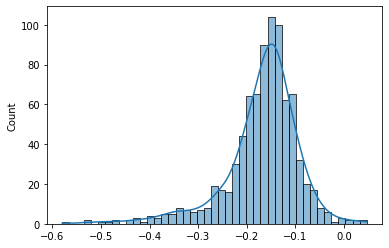

In [198]:
effect = reg.predict_effect(X)
sns.histplot(effect, kde=True)
effect.describe()

In [199]:
(effect<0).mean()

0.9928143712574851

[Text(0.5, 15.0, 'Treatment group'),
 Text(33.0, 0.5, 'Weight on treatment-specific model')]

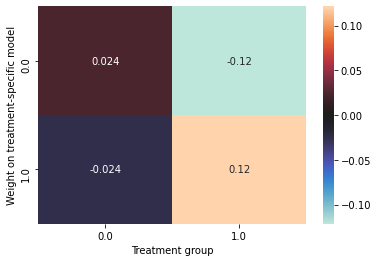

In [200]:
import seaborn as sns

weight_df = reg.weight_.copy()
weight_df = weight_df.apply(lambda x: x-reg.constrained_weight_)
ax = sns.heatmap(weight_df, center=0, annot=True)
ax.set(xlabel='Treatment group', ylabel='Weight on treatment-specific model')

In [148]:
from sklearn.model_selection import KFold, cross_val_score

scores = []
for i in range(10):
    print(i)
    score = {'C': [], 'UC': []}
    kf = KFold(10, shuffle=True)
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        reg.fit(X_train, y_train)
        reg.constrained = False
        score['UC'].append(reg.score(X_test, y_test))
        reg.constrained = True
        score['C'].append(reg.score(X_test, y_test))
    score = {key: np.array(val).mean() for key, val in score.items()}
    scores.append(score)

0
1
2
3
4
5
6
7
8
9


In [174]:
tmp_df = pd.DataFrame(scores)
tmp_df['Diff'] = tmp_df['UC'] - tmp_df['C']
tmp_df

,C,UC,Diff,RelDiff
0,0.166493,0.167700,0.001207,0.724846
1,0.162565,0.165250,0.002686,1.652033
2,0.174720,0.176074,0.001354,0.775238
3,0.142111,0.143363,0.001252,0.880883
4,0.167400,0.170374,0.002974,1.776708
5,0.176093,0.177627,0.001534,0.870879
6,0.160161,0.161388,0.001227,0.766259
7,0.164787,0.166409,0.001622,0.984444
8,0.168243,0.169847,0.001605,0.953761
9,0.157840,0.160064,0.002225,1.409362


In [175]:
tmp_df.mean()

C          0.164041
UC         0.165810
Diff       0.001769
RelDiff    1.079441
dtype: float64

In [201]:
from scipy.stats import ttest_1samp

res = ttest_1samp(tmp_df['Diff'], 0)
print(res.statistic, res.pvalue/2)

8.778162525277352 5.233530629410947e-06
